In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

Let's now evaluate the losses by also adding a validation loss which is tested on the test set. This way we can evaluate our model and see how much it's overfitting. We will also plot the loss per epoch instead of per batch as we normally did. Finally, we will use the RELU loss function which would make the training much faster. 

In [2]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_y)

[5 0 4 ... 5 6 8]


In [3]:
print("Training Set Details")
print("Target Categories:", np.unique(train_y))
print("Features: ", train_X.shape, train_X.dtype)
print("Classes:", train_y.shape, train_y.dtype)

print("Classes:", train_y)
print("Feature range:", np.min(train_X).astype(np.int32), np.max(train_X).astype(np.int32))
print("Feature type:",train_X.dtype)
print("Target type:",train_y.dtype)

Training Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (60000, 28, 28) uint8
Classes: (60000,) uint8
Classes: [5 0 4 ... 5 6 8]
Feature range: 0 255
Feature type: uint8
Target type: uint8


In [4]:
print("Test Set Details")
print("Target Categories:", np.unique(test_y))
print("Features: ", test_X.shape, test_X.dtype)
print("Classes:", test_y.shape, test_y.dtype)

print("Classes:", test_y)
print("Feature range:", np.min(test_X).astype(np.int32), np.max(test_X).astype(np.int32))
print("Feature type:",test_X.dtype)
print("Target type:",test_y.dtype)

Test Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (10000, 28, 28) uint8
Classes: (10000,) uint8
Classes: [7 2 1 ... 4 5 6]
Feature range: 0 255
Feature type: uint8
Target type: uint8


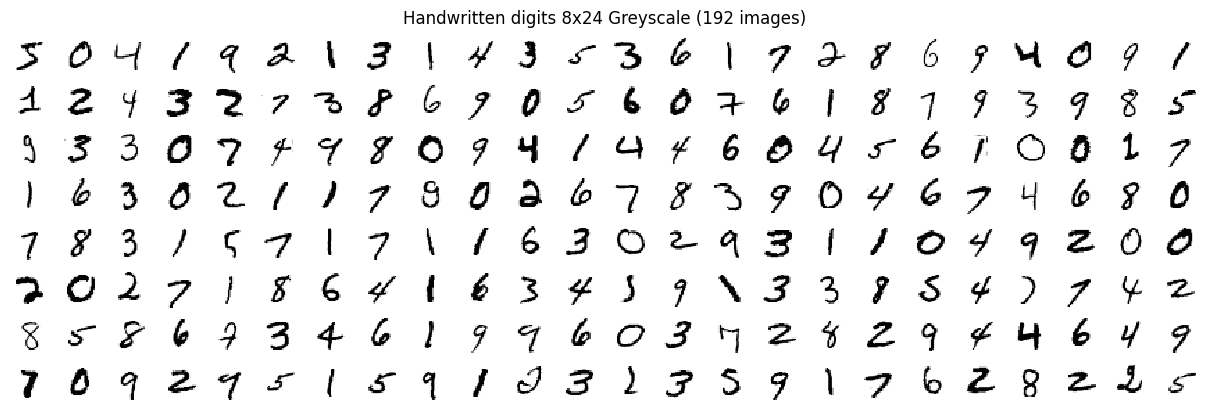

In [5]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(train_X[c].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

In [6]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

train_X = feature_scale(train_X, scaled=True) # feature scale the training set
test_X = feature_scale(test_X, scaled=True) # feature scale the test set

In [7]:
train_size = train_X.shape[0]
test_size = test_X.shape[0]
train_X = train_X.reshape((train_size,-1)) # reshape the training set
test_X = test_X.reshape((test_size,-1)) # reshape the test set
print("TrainX:",train_X.shape)
print("TestX:",test_X.shape)

TrainX: (60000, 784)
TestX: (10000, 784)


In [8]:
def add_bias_weight(data):
    m = data.shape[0]
    ones_feature = np.ones(m).reshape((-1,1)) # create a single feature of ones
    data_bias = np.hstack([data, ones_feature])
    return data_bias

train_X_bias = add_bias_weight(train_X)
test_X_bias = add_bias_weight(test_X)
print("TrainX+Bias:",train_X_bias.shape)
print("TestX+Bias:",test_X_bias.shape)

TrainX+Bias: (60000, 785)
TestX+Bias: (10000, 785)


In [9]:
def initialize_mlp_weight_matrices(feature_size, layer_sizes):
    layer_sizes = np.array(layer_sizes)
    layer_sizes += 1
    layer_sizes[-1] -= 1
    # here add 1 to every layer for the bias term except the last layer since the last layer is the categories. 
    
    weight_matrices = []
    previous_layer_size = feature_size
    for layer_size in layer_sizes:
        weight_matrix = np.random.random((previous_layer_size, layer_size)) * 0.01 # make sure to use smarter initialization strategies
        weight_matrices.append(weight_matrix)
        previous_layer_size = layer_size
    return weight_matrices

In [10]:
def create_mini_batches(x, y, batch_size):
    size = x.shape[0]
    indices = np.arange(size)
    np.random.shuffle(indices)
    shuffled_x = np.take(x, indices, axis=0)
    shuffled_y = np.take(y, indices, axis=0)
    
    batches = size // batch_size
    minibatches_x = np.array_split(shuffled_x, batches)
    minibatches_y = np.array_split(shuffled_y, batches)

    return minibatches_x, minibatches_y

In [11]:
def relu(x):
    return np.maximum(x, 0)

In [12]:
def relu_gradient(relu_matrix):
    return (relu_matrix > 0).astype(np.float64) # the greater than (> 0) is key here. it wouldn't work if we did greater than or equal to (>= 0) as every output will be 1 now.

In [13]:
def softmax(x):
    D = -np.max(x, axis=1) # D constant for the log sum exp trick. Useful to deal with limited precision, but the output is the exact same as the original sigmoid

    ez = np.exp((x.T + D).T)
    return ez / np.sum(ez, axis=1).reshape((-1,1))

In [14]:
def predict(weight_matrices, batch_x, activation_func, epsilon=1e-15):
    prediction = batch_x # m k
    for i in range(len(weight_matrices)):
        prediction = prediction @ weight_matrices[i] # matrix multiply by the previous output
        if i == len(weight_matrices) - 1: # at the very last layer don't apply the activation function
            break
        prediction = activation_func(prediction)

    softmax_predict = softmax(prediction) # pass it through a softmax
    prediction = np.clip(softmax_predict, epsilon, 1 - epsilon) # clip to avoid overflow issues
    return prediction

In [15]:
def onehot_matrix(a, categories):
    a = a.flatten()
    return np.eye(categories)[a]

In [16]:
def log_loss_cost(weight_matrices, x, y, activation_func, categories):
    onehot = onehot_matrix(y, categories) # m k
    softmax_prob = predict(weight_matrices, x, activation_func) # m k
    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    return -np.mean(overm) # 1

In [17]:
def compute_gradients(weight_matrices, batch_x, batch_y, activation_func, activation_gradient, categories, epsilon=1e-15):
    m = batch_x.shape[0] # number of batched examples
    k = categories # number of categories

    gradient_matrices = []
    for weight_matrix in weight_matrices:
        gradient_matrices.append(np.zeros_like(weight_matrix))
    # create the gradient matrices

    onehot = onehot_matrix(batch_y, k) # m k
    # create the onehot labels

    prediction = batch_x # m k
    matrices_state = [batch_x]

    for i in range(len(weight_matrices)):
        prediction = prediction @ weight_matrices[i]
        if i == len(weight_matrices) - 1:
            break
        prediction = activation_func(prediction)
        matrices_state.append(prediction)

    softmax_prob = softmax(prediction) # pass it through a softmax
    softmax_prob = np.clip(softmax_prob, epsilon, 1 - epsilon) # clip to avoid overflow issues
    # compute the softmax probability matrix

    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    loss = -np.mean(overm) # 1
    # compute the loss value

    diff = softmax_prob - onehot # m k
    # backprop for softmax

    previous_mat = diff
    for i in range(len(weight_matrices)-1,-1,-1):
        gradient_matrices[i] = np.matmul(matrices_state[i].T, previous_mat)
        if i == 0:
            break
        dw_activation = np.matmul(previous_mat, weight_matrices[i].T)
        previous_mat = activation_gradient(matrices_state[i]) * dw_activation

    return gradient_matrices

In [18]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Epoch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

In [19]:
def gradient_descent(train_x, train_y, test_x, test_y, gradient_func, cost_func, activation_func, activation_gradient, layer_sizes, learning_rate=0.01, max_epochs=1000, batch_size=64):
    train_y = train_y.reshape((-1,1)) # output classes
    m = train_x.shape[0] # number of training examples
    n = train_x.shape[1] # number of features
    k = np.unique(train_y).shape[0] # number of categories

    weight_matrices = initialize_mlp_weight_matrices(n, layer_sizes) # initialize weight matrices for each layer

    training_costs = np.empty(0)
    test_costs = np.empty(0)

    for epoch in range(max_epochs):
        minibatches_x, minibatches_y = create_mini_batches(train_x, train_y, batch_size)
        
        temp_training_costs = np.array([])
        for batch_x, batch_y in zip(minibatches_x, minibatches_y):
            gradient_matrices = gradient_func(weight_matrices, batch_x, batch_y, activation_func, activation_gradient, k)

            for i in range(len(layer_sizes)):
                weight_matrices[i] -= learning_rate * gradient_matrices[i]
            # update the weights per each matrix
            
            training_cost = cost_func(weight_matrices, batch_x, batch_y, activation_func, k)
            temp_training_costs = np.append(temp_training_costs, training_cost)
            # add to array for visualization

        minibatches_x, minibatches_y = create_mini_batches(test_x, test_y, batch_size)

        temp_test_costs = np.array([])
        for batch_x, batch_y in zip(minibatches_x, minibatches_y):
            test_cost = cost_func(weight_matrices, batch_x, batch_y, activation_func, k)
            temp_test_costs = np.append(temp_test_costs, test_cost)

        training_costs = np.append(training_costs, np.mean(temp_training_costs)) # average the cost per epoch over all the batches
        test_costs = np.append(test_costs, np.mean(temp_test_costs))

    return weight_matrices, training_costs, test_costs

In [20]:
layer_sizes = [256,128,10]
relu_weight_matrices, relu_training_costs, relu_test_costs = gradient_descent(train_X_bias, train_y, test_X_bias, test_y, compute_gradients, log_loss_cost, relu, relu_gradient, layer_sizes, learning_rate=0.001, max_epochs=20, batch_size=64)

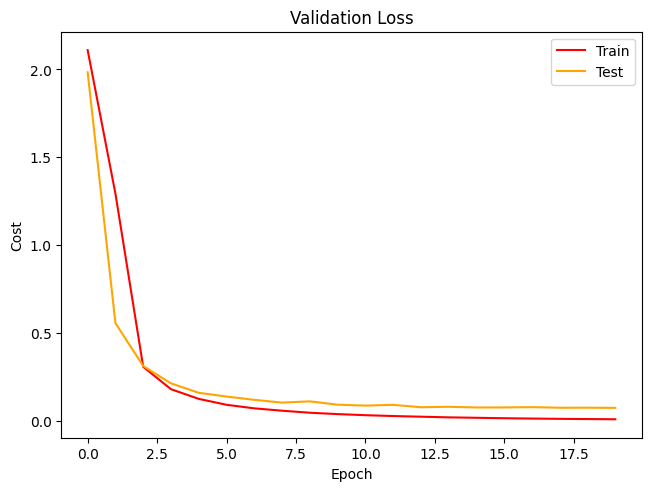

In [21]:
iterations = relu_training_costs.shape[0]
iteration_array = np.arange(0, iterations, dtype=np.int32)

# graph the cost after updating the model
_, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Epoch")
cost_graph.set_ylabel("Cost")

cost_graph.set_title("Validation Loss")

cost_graph.plot(iteration_array, relu_training_costs, color='red', label="Train")
cost_graph.plot(iteration_array, relu_test_costs, color='orange', label="Test")
plt.legend()

From this curve, there are many things to observe. Firsly, the model already converges after only 5 epochs or so. A massive drop happens in the initial training. After that, eventually both the training loss and the test loss settle to some margin. Then, the test loss is a bit higher than the training loss which obviously is the case. Here, it isn't too much higher than the training loss so the model hasn't overfit. Also, plotting the graph over epochs is much nicer than with batches as it looks less noisy. Regardless, this is a cheap way to evaluate a model. 